![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [6]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [8]:
df=df.sample(100000)

In [9]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
122591,122591,91202,105399,How is the chemical formula of hydrochloric so...,What is the chemical formula for sodium hydrog...,0
128871,128871,99125,15098,How can someone become rich?,How can I become rich man?,1
62931,62931,109592,109593,What is Riemann zeta function and why is it a ...,What is the Riemann Zeta Function and its purp...,1
23915,23915,44752,44753,Telugu Film Industry: What you hate the most a...,Who is A1 star in telugu?,0
4078,4078,8072,8073,Why were Russia's casualties so disproportiona...,Why were Soviet casualties so high even late war?,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 122591 to 384135
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 5.3+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

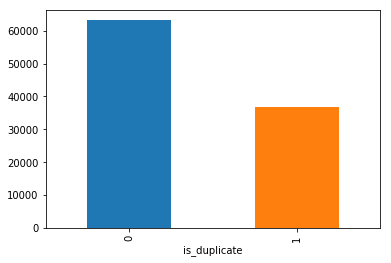

In [11]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [12]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   100000


In [13]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.15%

~> Question pairs are Similar (is_duplicate = 1):
   36.85%


<h3> 3.2.2 Number of unique questions </h3>

In [14]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 166239

Number of unique questions that appear more than one time: 19305 (11.612798440799091%)

Max number of times a single question is repeated: 39



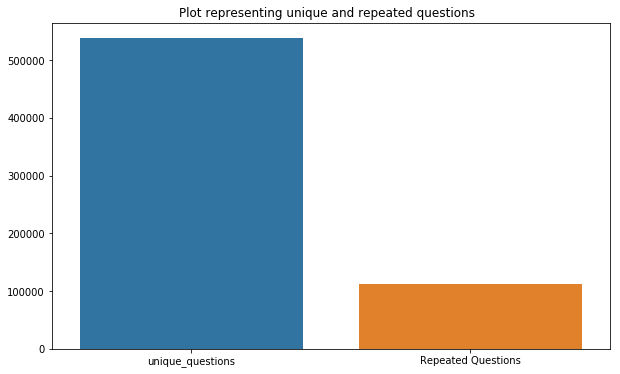

In [12]:
x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [15]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()
print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 39



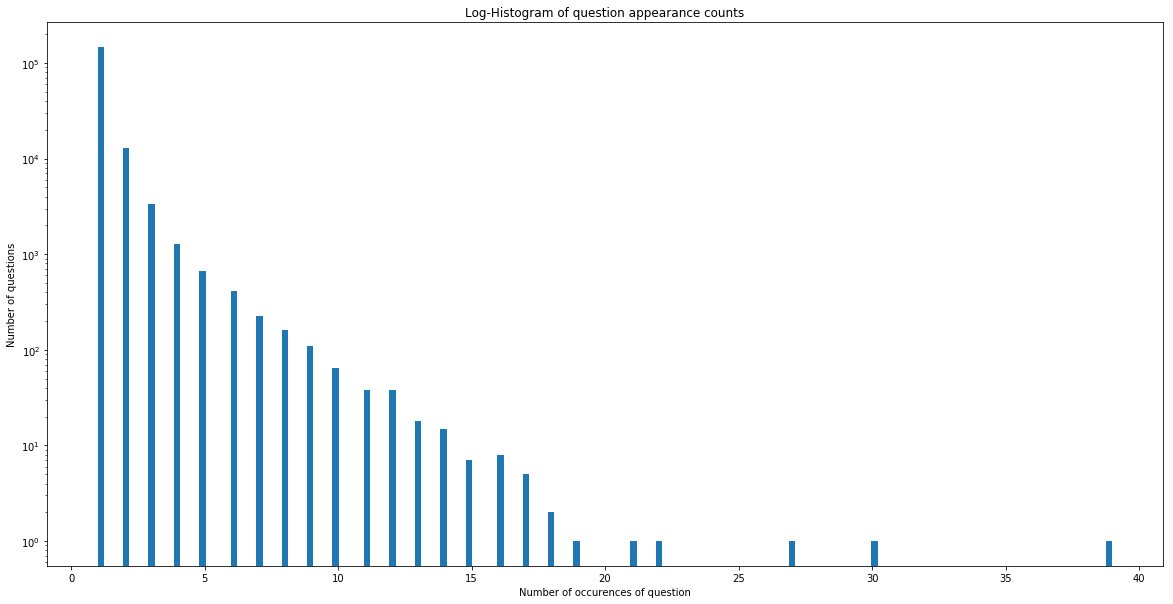

In [16]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [17]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


There are no null values in our data

<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [18]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
122591,122591,91202,105399,How is the chemical formula of hydrochloric so...,What is the chemical formula for sodium hydrog...,0,1,1,62,79,9,13,7.0,21.0,0.333333,2,0
128871,128871,99125,15098,How can someone become rich?,How can I become rich man?,1,2,3,28,26,5,6,3.0,11.0,0.272727,5,1
62931,62931,109592,109593,What is Riemann zeta function and why is it a ...,What is the Riemann Zeta Function and its purp...,1,1,1,55,59,12,11,6.0,21.0,0.285714,2,0
23915,23915,44752,44753,Telugu Film Industry: What you hate the most a...,Who is A1 star in telugu?,0,1,1,73,25,12,6,1.0,18.0,0.055556,2,0
4078,4078,8072,8073,Why were Russia's casualties so disproportiona...,Why were Soviet casualties so high even late war?,0,1,1,76,49,11,9,5.0,20.0,0.250000,2,0


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [19]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 14
Number of Questions with minimum length [question2] : 8


<h4> 3.3.1.1 Feature: word_share </h4>

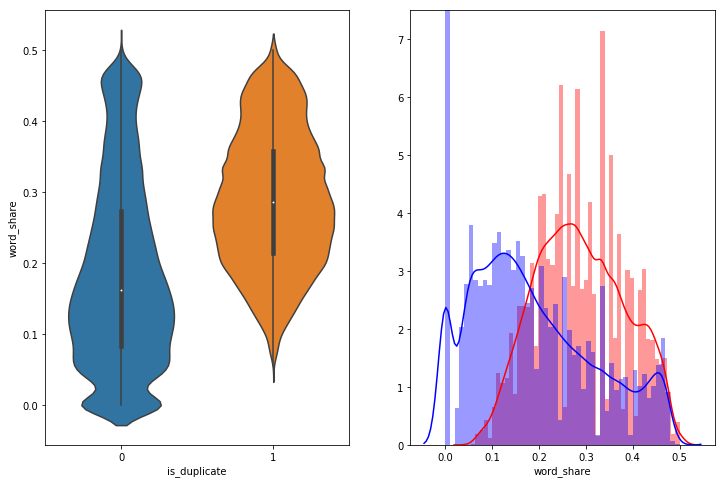

In [20]:
import warnings
warnings.filterwarnings("ignore")
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

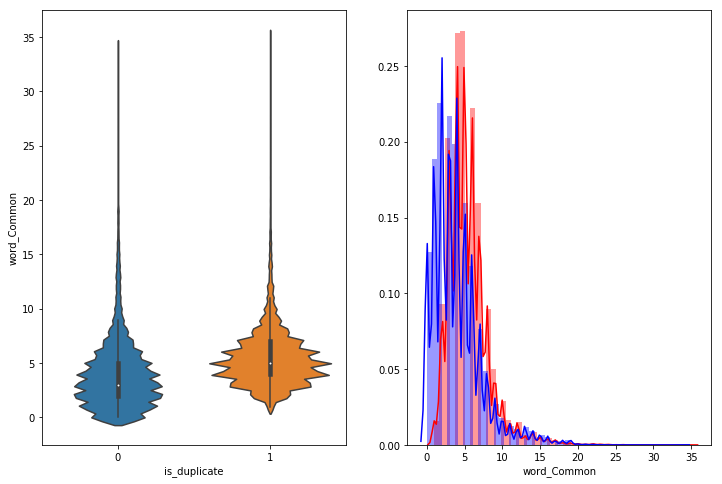

In [21]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

### 1.2.1 : EDA: Advanced Feature Extraction.


In [2]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [23]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [24]:
df.to_csv('newtrain.csv',sep='\t')
df.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,122591,91202,105399,How is the chemical formula of hydrochloric so...,What is the chemical formula for sodium hydrog...,0,1,1,62,79,9,13,7.0,21.0,0.333333,2,0
1,128871,99125,15098,How can someone become rich?,How can I become rich man?,1,2,3,28,26,5,6,3.0,11.0,0.272727,5,1


<h2> 3.4 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [25]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [26]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [46]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("newtrain.csv",sep='\t')
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,122591,91202,105399,how is the chemical formula of hydrochloric so...,what is the chemical formula for sodium hydrog...,0,1,1,62,...,0.538457,1.0,0.0,4.0,11.0,85,75,68,65,0.396825
1,1,128871,99125,15098,how can someone become rich,how can i become rich man,1,2,3,28,...,0.666656,0.0,1.0,1.0,5.5,86,73,77,73,0.481481


In [47]:
df.shape

Index(['Unnamed: 0', 'id', 'qid1', 'qid2', 'question1', 'question2',
       'is_duplicate', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [48]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s',encoding='latin-1')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s',encoding='latin-1')

Number of data points in class 1 (duplicate pairs) : 73692
Number of data points in class 0 (non duplicate pairs) : 126308


In [50]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt'),encoding="latin-1").read()
textn_w = open(path.join(d, 'train_n.txt'),encoding="latin-1").read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 3985596
Total number of words in non duplicate pair questions : 8225465


__ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


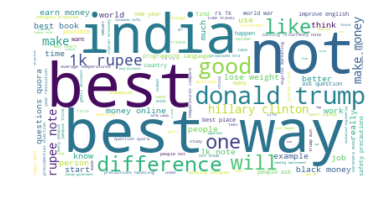

In [51]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


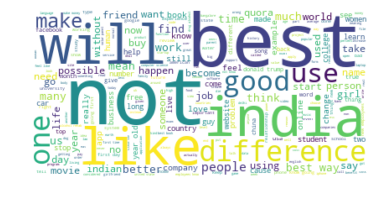

In [52]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

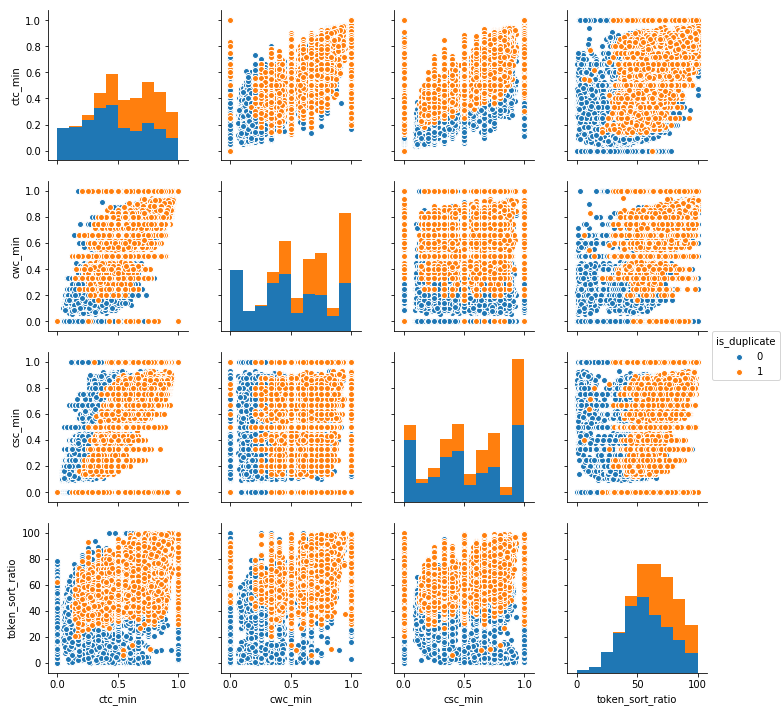

In [53]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

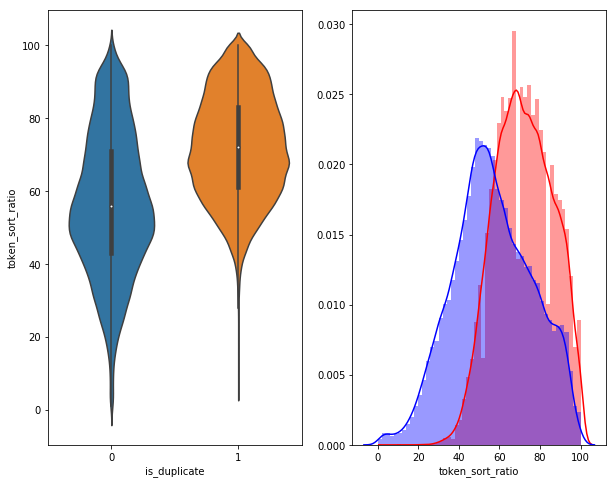

In [54]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

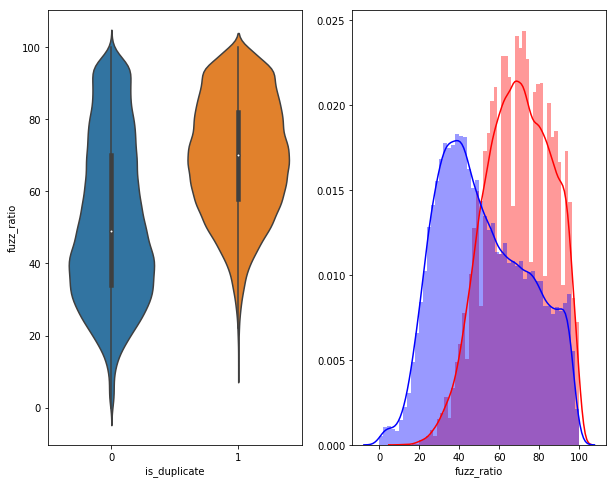

In [55]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [56]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention
from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [57]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.125s...
[t-SNE] Computed neighbors for 5000 samples in 2.063s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.143717
[t-SNE] Computed conditional probabilities in 1.328s
[t-SNE] Iteration 50: error = 81.5860672, gradient norm = 0.0461458 (50 iterations in 34.462s)
[t-SNE] Iteration 100: error = 70.6786804, gradient norm = 0.0092161 (50 iterations in 28.737s)
[t-SNE] Iteration 150: error = 68.8469925, gradient norm = 0.0056998 (50 iterations in 23.688s)
[t-SNE] Iteration 200: error = 68.1304550, gradient norm = 0.0038048 (50 iterations in 23.836s)
[t-SNE] Iteration 250: error = 67.7164383, gradient norm = 0.003

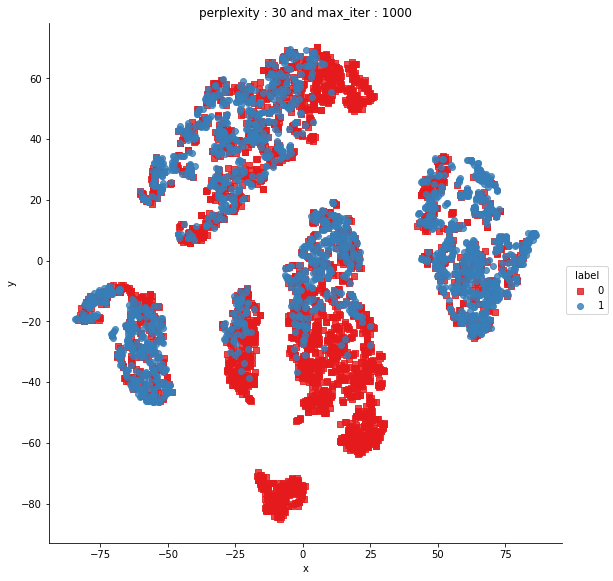

In [58]:
dftsne = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=dftsne, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [59]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.063s...
[t-SNE] Computed neighbors for 5000 samples in 1.922s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.143717
[t-SNE] Computed conditional probabilities in 1.156s
[t-SNE] Iteration 50: error = 81.8794403, gradient norm = 0.0345724 (50 iterations in 66.075s)
[t-SNE] Iteration 100: error = 69.7194138, gradient norm = 0.0041800 (50 iterations in 32.508s)
[t-SNE] Iteration 150: error = 68.3212662, gradient norm = 0.0018615 (50 iterations in 26.893s)
[t-SNE] Iteration 200: error = 67.7656326, gradient norm = 0.0013245 (50 iterations in 27.258s)
[t-SNE] Iteration 250: error = 67.4306259, gradient norm = 0.001

In [60]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

In [63]:
df.columns

Index(['Unnamed: 0', 'id', 'qid1', 'qid2', 'question1', 'question2',
       'is_duplicate', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len',
       'q1_n_words', 'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       'freq_q1+q2', 'freq_q1-q2', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max',
       'ctc_min', 'ctc_max', 'last_word_eq', 'first_word_eq', 'abs_len_diff',
       'mean_len', 'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [64]:
df.drop(['Unnamed: 0','id'], axis=1, inplace=True)

In [65]:
df.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'is_duplicate', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [66]:
df.shape

(100000, 31)

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools
import spacy

In [68]:
df.head()

,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,91202,105399,how is the chemical formula of hydrochloric so...,what is the chemical formula for sodium hydrog...,0,1,1,62,79,9,...,0.538457,1.0,0.0,4.0,11.0,85,75,68,65,0.396825
1,99125,15098,how can someone become rich,how can i become rich man,1,2,3,28,26,5,...,0.666656,0.0,1.0,1.0,5.5,86,73,77,73,0.481481
2,109592,109593,what is riemann zeta function and why is it a ...,what is the riemann zeta function and its purp...,1,1,1,55,59,12,...,0.499996,0.0,1.0,1.0,11.5,79,70,73,73,0.482143
3,44752,44753,telugu film industry what you hate the most a...,who is a1 star in telugu,0,1,1,73,25,12,...,0.166665,0.0,0.0,6.0,9.0,63,44,12,44,0.269231
4,8072,8073,why were russia own casualties so disproportio...,why were soviet casualties so high even late war,0,1,1,76,49,11,...,0.499996,0.0,1.0,3.0,10.5,78,56,61,61,0.300000


In [69]:
Y_labels=df['is_duplicate']
print(df.shape)
print(Y_labels.shape)
df.drop(['is_duplicate'],axis=1,inplace=True)
print(df.shape)

(100000, 31)
(100000,)
(100000, 30)


# TRAIN,CV,TEST SPLIT

In [72]:
from sklearn.model_selection import train_test_split
X_train,X_test, Y_train, Y_test = train_test_split(df,Y_labels,stratify=Y_labels,test_size=0.3)

In [73]:
X_train,X_cv,Y_train,Y_cv = train_test_split(X_train,Y_train,test_size=0.33)

In [74]:
print("Number of data points in train data:",X_train.shape,Y_train.shape)
print("Number of data points in cv data :",X_cv.shape,Y_cv.shape)
print("Number of data points in test data :",X_test.shape,Y_test.shape)

Number of data points in train data: (46900, 30) (46900,)
Number of data points in cv data : (23100, 30) (23100,)
Number of data points in test data : (30000, 30) (30000,)


Featurization for train data

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_train['question1']) + list(X_train['question2'])

tfidftrain = TfidfVectorizer(lowercase=False,min_df=10)
tfidftrain.fit_transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidftrain.get_feature_names(), tfidftrain.idf_))

In [138]:
X_train = X_train.drop(X_train.index[40272])

In [139]:
print(X_train.iloc[40272]['question1'])
#X_train.set_value(34549,'question1','how', takeable=False)
#X_train.iloc[34549]['question1']='what'

what are the major stereotypes people have about burkina faso and to what extent are they true 


In [147]:
for i in range(0,46897):
    if(X_train.iloc[i]['question2']==''):
        print(i)

7191


In [148]:
X_train.iloc[7191]['question2']

''

In [157]:
Y_train = Y_train.drop(Y_train.index[34549])
Y_train = Y_train.drop(Y_train.index[40272])
Y_train = Y_train.drop(Y_train.index[7191])

- After we find TF-IDF scores, we convert each question to a weighted average of word2vec vectors by these scores.
- here we use a pre-trained GLOVE model which comes free with "Spacy".  https://spacy.io/usage/vectors-similarity
- It is trained on Wikipedia and therefore, it is stronger in terms of word semantics. 

In [ ]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_train['q1_feats_m'] = list(vecs1)

In [143]:
X_train.shape

(46898, 31)

In [ ]:
X_train = X_train.drop(X_train.index[7191])

In [154]:
vecs2 = []
for qu2 in tqdm(list(X_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_train['q2_feats_m'] = list(vecs2)

100%|███████████████████████████████████▉| 46807/46897 [29:13<00:02, 33.08it/s]







100%|███████████████████████████████████▉| 46811/46897 [29:13<00:02, 32.75it/s]







100%|███████████████████████████████████▉| 46815/46897 [29:14<00:02, 32.52it/s]







100%|███████████████████████████████████▉| 46819/46897 [29:14<00:02, 30.08it/s]







100%|███████████████████████████████████▉| 46823/46897 [29:14<00:02, 30.63it/s]







100%|███████████████████████████████████▉| 46827/46897 [29:14<00:02, 31.03it/s]







100%|███████████████████████████████████▉| 46831/46897 [29:14<00:02, 31.31it/s]







100%|███████████████████████████████████▉| 46835/46897 [29:14<00:01, 31.52it/s]







100%|███████████████████████████████████▉| 46839/46897 [29:14<00:01, 32.88it/s]







100%|███████████████████████████████████▉| 46843/46897 [29:14<00:01, 33.91it/s]







100%|███████████████████████████████████▉| 46847/46897 [29:14<00:01, 34.66it/s]







100%|███████████████████████████████████▉| 

In [159]:
print(X_train.shape)
print(Y_train.shape)

(46897, 32)
(46897,)


In [160]:
X_train1=X_train
Y_train1=Y_train

In [161]:
print(X_train1.shape)
print(Y_train1.shape)

(46897, 32)
(46897,)


In [162]:
X_train1['Y_labels']=Y_train1

In [165]:
X_train1.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio', 'q1_feats_m', 'q2_feats_m', 'Y_labels'],
      dtype='object')

In [167]:
X_train1.to_csv("tfidfw2v_train.csv",sep='\t')

In [168]:
X_test1=X_test
Y_test1=Y_test
X_cv1=X_cv
Y_cv1=Y_cv

In [171]:
X_test1['Y_labels']=Y_test1
X_cv1['Y_labels']=Y_cv1

In [172]:
print(X_test1.shape)
print(X_cv1.shape)

(30000, 31)
(23100, 31)


In [173]:
X_test1.to_csv("X_test1beforetfidfw2v.csv",sep='\t')#saving x_test1 to csv
X_cv1.to_csv("X_cv1beforetfidfw2v.csv",sep='\t')#saving X_cv1 to csv 

In [177]:
X_train[0:5]

,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,...,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio,q1_feats_m,q2_feats_m,Y_labels
71952,248426,248427,is telegram more popular than whatsapp,is telegram messenger secure is it more secur...,1,1,39,62,6,10,...,4.0,8.0,88,67,67,70,0.375000,"[-68.99339246749878, -42.90584480762482, -9.32...","[-57.206102311611176, -136.98543465137482, 10....",0
70086,6917,6918,what is the difference between first and third...,why do people think of third party cookies as ...,1,1,61,51,9,9,...,0.0,10.0,60,56,51,57,0.403846,"[2.461588740348816, -42.61937117576599, -87.49...","[14.727312088012695, -27.751273445785046, -80....",0
23672,329584,329585,will indian muslims feel safer if asaduddin ow...,india will indian muslims feel safer if asadu...,1,1,75,130,13,22,...,9.0,17.5,100,74,73,100,0.986842,"[35.774293422698975, 8.516327142715454, -51.55...","[106.50853662192822, -21.88571572303772, -50.1...",1
5775,526150,526151,if our parents never taught us to walk when we...,why are indian parents not able to control the...,1,1,97,93,20,17,...,3.0,18.5,52,51,44,44,0.106383,"[73.0918687582016, 159.8301381766796, 6.335695...","[-9.409424245357513, 33.95170068740845, -70.43...",0
55090,471635,471636,what reforms does agriculture in india need,how many cities have been the largest city in ...,1,1,44,103,7,19,...,13.0,13.5,21,23,24,36,0.088889,"[87.55459773540497, -37.50277614593506, -18.70...","[143.47709292173386, -54.97777634859085, -111....",0


In [178]:
df3 = X_train.drop(['qid1','qid2','question1','question2','Y_labels'],axis=1)
df3_q1 = pd.DataFrame(X_train.q1_feats_m.values.tolist(), index= X_train.index)
df3_q2 = pd.DataFrame(X_train.q2_feats_m.values.tolist(), index= X_train.index)

In [190]:
df3.columns

Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'q1_feats_m',
       'q2_feats_m'],
      dtype='object')

In [191]:
df3=df3.drop(['q1_feats_m','q2_feats_m'],axis=1)

In [193]:
print(df3[0:5])
print(df3_q1[0:5])
print(df3_q2[0.5])

       freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
71952          1          1     39     62           6          10   
70086          1          1     61     51           9           9   
23672          1          1     75    130          13          22   
5775           1          1     97     93          20          17   
55090          1          1     44    103           7          19   

       word_Common  word_Total  word_share  freq_q1+q2          ...           \
71952          5.0        15.0    0.333333           2          ...            
70086          1.0        18.0    0.055556           2          ...            
23672         13.0        34.0    0.382353           2          ...            
5775           4.0        33.0    0.121212           2          ...            
55090          1.0        23.0    0.043478           2          ...            

        ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
71952  0.499995           1.0   

KeyError: 0.5

In [194]:
print("Number of features in question1 w2v  dataframe :", df3_q1.shape[1])
print("Number of features in question2 w2v  dataframe :", df3_q2.shape[1])
print("Number of features in final dataframe  :", df3.shape[1]+df3_q1.shape[1]+df3_q2.shape[1])

Number of features in question1 w2v  dataframe : 96
Number of features in question2 w2v  dataframe : 96
Number of features in final dataframe  : 218


In [196]:
frame1=df3
frame2=df3_q1
frame3=df3_q2

In [204]:
final_dataframe_train=frame1.join(frame2).join(frame3,lsuffix='_1', rsuffix='_2')

In [206]:
print(final_dataframe_train.shape)
print(final_dataframe_train.columns)
final_dataframe_train['Y_labels']=Y_train
print(final_dataframe_train.shape)
print(final_dataframe_train.columns)

(46897, 218)
Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       ...
       '86_2', '87_2', '88_2', '89_2', '90_2', '91_2', '92_2', '93_2', '94_2',
       '95_2'],
      dtype='object', length=218)
(46897, 219)
Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       ...
       '87_2', '88_2', '89_2', '90_2', '91_2', '92_2', '93_2', '94_2', '95_2',
       'Y_labels'],
      dtype='object', length=219)


In [207]:
final_dataframe_train.to_csv('final_dataframe_train.csv',sep='\t')

Featurization for cv data

In [9]:
X_cv=pd.read_csv("X_cv1beforetfidfw2v.csv",sep='\t')
print(X_cv.columns)

Index(['Unnamed: 0', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'Y_labels'],
      dtype='object')


In [10]:
Y_cv=X_cv['Y_labels']

In [13]:
X_cv.shape

(23100, 32)

In [14]:
#checking for empty questions
for i in range(0,23099):
    if(X_cv.iloc[i]['question1']==''):
        print(i)
    if(X_cv.iloc[i]['question2']==''):
        print(i)

In [ ]:
questions = list(X_cv['question1']) + list(X_cv['question2'])

tfidfcv=tfidftrain.transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidfcv.get_feature_names(), tfidfcv.idf_))

In [17]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_cv['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_cv['q1_feats_m'] = list(vecs1)

100%|████████████████████████████████████| 23100/23100 [14:33<00:00, 26.43it/s]


In [18]:
X_cv.shape

(23100, 33)

In [19]:
vecs2 = []
for qu2 in tqdm(list(X_cv['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_cv['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████| 23100/23100 [14:46<00:00, 26.07it/s]


In [20]:
X_cv.shape

(23100, 34)

In [22]:
df2 = X_cv.drop(['qid1','qid2','question1','question2','Y_labels'],axis=1)
df2_q1 = pd.DataFrame(X_cv.q1_feats_m.values.tolist(), index= X_cv.index)
df2_q2 = pd.DataFrame(X_cv.q2_feats_m.values.tolist(), index= X_cv.index)

In [24]:
df2=df2.drop(['q1_feats_m','q2_feats_m'],axis=1)

In [28]:
df2=df2.drop(['Unnamed: 0'],axis=1)

In [34]:
print(df2[0:2])
print(df2_q1[0:2])
print(df2_q2[0:2])

   freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  \
0          1          2     44     66           9          14          4.0   
1          1          1     58     51           9           9          7.0   

   word_Total  word_share  freq_q1+q2          ...            ctc_max  \
0        22.0    0.181818           3          ...           0.285712   
1        16.0    0.437500           2          ...           0.777769   

   last_word_eq  first_word_eq  abs_len_diff  mean_len  token_set_ratio  \
0           0.0            1.0           5.0      11.5               57   
1           1.0            1.0           0.0       9.0               93   

   token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0                44          56                  64              0.222222  
1                90          90                  82              0.538462  

[2 rows x 26 columns]
          0          1          2          3          4          5  

In [65]:
frame1=df2
frame2=df2_q1
frame3=df2_q2

In [66]:
final_dataframe_cv=frame1.join(frame2).join(frame3,lsuffix='_1', rsuffix='_2')

In [67]:
X_cv=final_dataframe_cv

In [32]:
print(final_dataframe_cv.shape)
print(final_dataframe_cv.columns)
final_dataframe_cv['Y_labels']=Y_cv
print(final_dataframe_cv.shape)
print(final_dataframe_cv.columns)

(23100, 218)
Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       ...
       '86_2', '87_2', '88_2', '89_2', '90_2', '91_2', '92_2', '93_2', '94_2',
       '95_2'],
      dtype='object', length=218)
(23100, 219)
Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       ...
       '87_2', '88_2', '89_2', '90_2', '91_2', '92_2', '93_2', '94_2', '95_2',
       'Y_labels'],
      dtype='object', length=219)


In [33]:
final_dataframe_cv.to_csv('final_dataframe_cv.csv',sep='\t')

Featurization for test data

In [35]:
X_test=pd.read_csv("X_test1beforetfidfw2v.csv",sep='\t')
print(X_test.columns)

Index(['Unnamed: 0', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'Y_labels'],
      dtype='object')


In [36]:
Y_test=X_test['Y_labels']
X_test.shape

(30000, 32)

In [38]:
#checking for empty questions
for i in range(0,29999):
    if(X_test.iloc[i]['question1']==''):
        print(i)
    if(X_test.iloc[i]['question2']==''):
        print(i)

In [39]:
questions = list(X_test['question1']) + list(X_test['question2'])

tfidftest=tfidftrain.transform(questions)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidftest.get_feature_names(), tfidftest.idf_))

In [40]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), len(doc1[0].vector)])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
X_test['q1_feats_m'] = list(vecs1)

100%|████████████████████████████████████| 30000/30000 [19:16<00:00, 25.93it/s]


In [42]:
vecs2 = []
for qu2 in tqdm(list(X_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), len(doc2[0].vector)])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
X_test['q2_feats_m'] = list(vecs2)

100%|████████████████████████████████████| 30000/30000 [19:19<00:00, 25.88it/s]


In [43]:
X_test.shape

(30000, 34)

In [44]:
df1 = X_test.drop(['Unnamed: 0','qid1','qid2','question1','question2','Y_labels'],axis=1)
df1_q1 = pd.DataFrame(X_test.q1_feats_m.values.tolist(), index= X_test.index)
df1_q2 = pd.DataFrame(X_test.q2_feats_m.values.tolist(), index= X_test.index)

In [45]:
df1=df1.drop(['q1_feats_m','q2_feats_m'],axis=1)

In [46]:
print(df1[0:2])
print(df1_q1[0:2])
print(df1_q2[0:2])

   freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  \
0          1          1     34     24           5           3          3.0   
1          1          1     87     27          16           4          0.0   

   word_Total  word_share  freq_q1+q2          ...            ctc_max  \
0         8.0       0.375           2          ...           0.599988   
1        18.0       0.000           2          ...           0.000000   

   last_word_eq  first_word_eq  abs_len_diff  mean_len  token_set_ratio  \
0           1.0            0.0           2.0       4.0              100   
1           0.0            0.0          11.0       9.5               22   

   token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0                82          82                 100              0.960000  
1                20          12                  37              0.071429  

[2 rows x 26 columns]
          0          1          2           3          4          5 

In [47]:
frame1=df1
frame2=df1_q1
frame3=df1_q2

In [59]:
final_dataframe_test=frame1.join(frame2).join(frame3,lsuffix='_1', rsuffix='_2')

In [193]:
X_test=final_dataframe_test

In [49]:
print(final_dataframe_test.shape)
print(final_dataframe_test.columns)
final_dataframe_test['Y_labels']=Y_test
print(final_dataframe_test.shape)
print(final_dataframe_test.columns)

(30000, 218)
Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       ...
       '86_2', '87_2', '88_2', '89_2', '90_2', '91_2', '92_2', '93_2', '94_2',
       '95_2'],
      dtype='object', length=218)
(30000, 219)
Index(['freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2',
       ...
       '87_2', '88_2', '89_2', '90_2', '91_2', '92_2', '93_2', '94_2', '95_2',
       'Y_labels'],
      dtype='object', length=219)


In [50]:
final_dataframe_test.to_csv('final_dataframe_test.csv',sep='\t')

<h1>4. Machine Learning Models </h1>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import sqlite3
from sqlalchemy import create_engine # database connection
import csv
import os
warnings.filterwarnings("ignore")
import datetime as dt
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from collections import Counter, defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier



from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from mlxtend.classifier import StackingClassifier

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [4]:
X_train=pd.read_csv('final_dataframe_train.csv',sep='\t')
X_cv=pd.read_csv('final_dataframe_cv.csv',sep='\t')
X_test=pd.read_csv('final_dataframe_test.csv',sep='\t')

In [5]:
print(X_train.shape)
print(X_train.columns)
print(X_cv.shape)
print(X_cv.columns)
print(X_test.shape)
print(X_test.columns)

(46897, 220)
Index(['Unnamed: 0', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       ...
       '87_2', '88_2', '89_2', '90_2', '91_2', '92_2', '93_2', '94_2', '95_2',
       'Y_labels'],
      dtype='object', length=220)
(23100, 220)
Index(['Unnamed: 0', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       ...
       '87_2', '88_2', '89_2', '90_2', '91_2', '92_2', '93_2', '94_2', '95_2',
       'Y_labels'],
      dtype='object', length=220)
(30000, 220)
Index(['Unnamed: 0', 'freq_qid1', 'freq_qid2', 'q1len', 'q2len', 'q1_n_words',
       'q2_n_words', 'word_Common', 'word_Total', 'word_share',
       ...
       '87_2', '88_2', '89_2', '90_2', '91_2', '92_2', '93_2', '94_2', '95_2',
       'Y_labels'],
      dtype='object', length=220)


In [6]:
Test_data=pd.read_csv('X_test1beforetfidfw2v.csv',sep='\t')#features before tfidfvecs

In [7]:
Y_train=X_train['Y_labels']
Y_cv=X_cv['Y_labels']
X_train=X_train.drop(['Unnamed: 0','Y_labels'],axis=1)
X_cv=X_cv.drop(['Unnamed: 0','Y_labels'],axis=1)
X_test=X_test.drop(['Unnamed: 0','Y_labels'],axis=1)

In [8]:
Y_test=Test_data['Y_labels']

In [9]:
print(X_train.shape,Y_train.shape)
print(X_cv.shape,Y_cv.shape)
print(X_test.shape,Y_test.shape)

(46897, 218) (46897,)
(23100, 218) (23100,)
(30000, 218) (30000,)


In [10]:
Y_test.value_counts()

0    18946
1    11054
Name: Y_labels, dtype: int64

In [11]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(Y_train)
train_len = len(Y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in cv data", "-"*10)
cv_distr = Counter(Y_cv)
cv_len = len(Y_cv)
print("Class 0: ",int(cv_distr[0])/cv_len, "Class 1: ",int(cv_distr[1])/cv_len)
print("-"*10, "Distribution of output variable in test data", "-"*10)
test_distr = Counter(Y_test)
test_len = len(Y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6296564812248118 Class 1:  0.3703435187751882
---------- Distribution of output variable in cv data ----------
Class 0:  0.6353246753246753 Class 1:  0.36467532467532465
---------- Distribution of output variable in test data ----------
Class 0:  0.6315333333333333 Class 1:  0.36846666666666666


In [12]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 4.4 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 0.8784882456245743


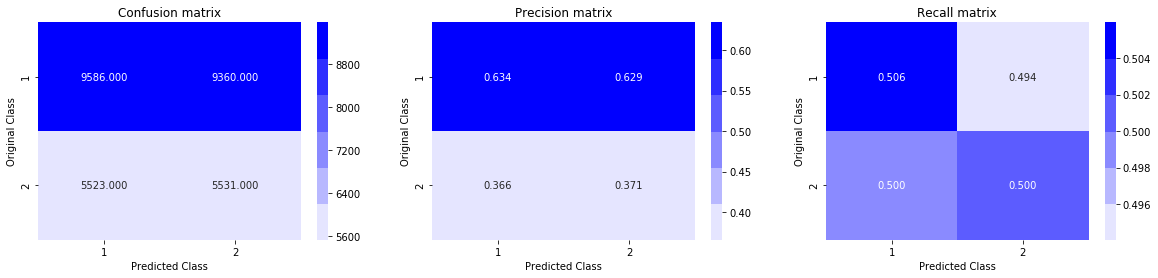

In [13]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(Y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(Y_test, predicted_y)

<h2> 4.4 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.586475909566314
For values of alpha =  0.0001 The log loss is: 0.5710440175955165
For values of alpha =  0.001 The log loss is: 0.5708057195276982
For values of alpha =  0.01 The log loss is: 0.5724987458384916
For values of alpha =  0.1 The log loss is: 0.5633782656579832
For values of alpha =  1 The log loss is: 0.5597354044109565
For values of alpha =  10 The log loss is: 0.5464755257531583


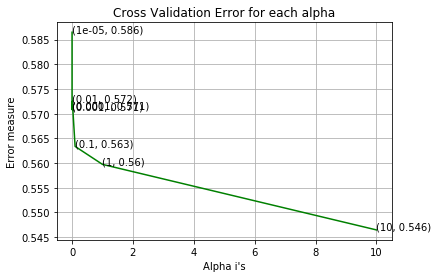

For values of best alpha =  10 The train log loss is: 0.5459594935008558
For values of best alpha =  10 The test log loss is: 0.5493626783230818
Total number of data points : 30000


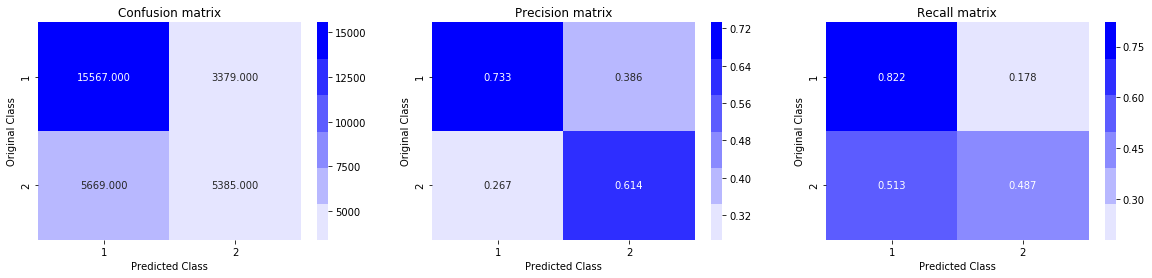

In [14]:
# warnings.filterwarnings("ignore")
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight='balanced')
    clf.fit(X_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, Y_train)
    predict_cv = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(Y_cv, predict_cv, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_cv, predict_cv, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(X_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, Y_train)

predict_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_train, labels=clf.classes_, eps=1e-15))
predict_test = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_test, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_test,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

<h2> 4.5 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.6561303011964124
For values of alpha =  0.0001 The log loss is: 0.5370106740256855
For values of alpha =  0.001 The log loss is: 0.5406352521097417
For values of alpha =  0.01 The log loss is: 0.5805544693066998
For values of alpha =  0.1 The log loss is: 0.6156313788837544
For values of alpha =  1 The log loss is: 0.6308986096117568
For values of alpha =  10 The log loss is: 0.6541648436974296


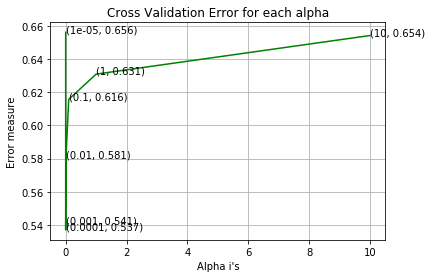

For values of best alpha =  0.0001 The train log loss is: 0.5410394985042342
For values of best alpha =  0.0001 The test log loss is: 0.5412808327360703
Total number of data points : 30000


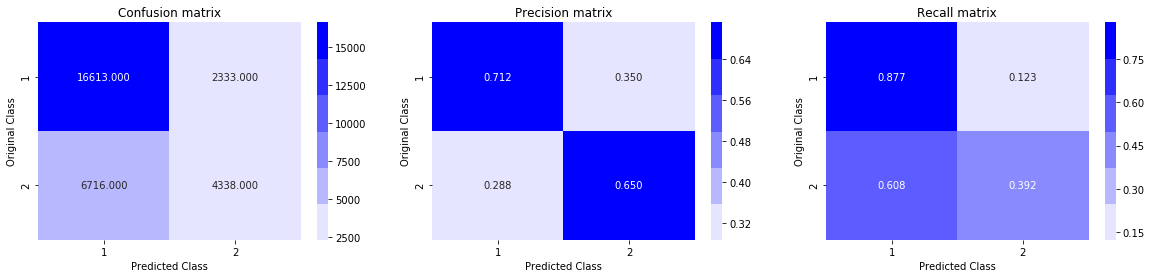

In [15]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
    clf.fit(X_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, Y_train)
    predict_cv = sig_clf.predict_proba(X_cv)
    log_error_array.append(log_loss(Y_cv,predict_cv, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_cv,predict_cv, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
clf.fit(X_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, Y_train)

predict_train = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_train, labels=clf.classes_, eps=1e-15))
predict_test = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_test, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_test,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

<h2> 4.6 XGBoost </h2>

In [45]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=Y_train)
d_test = xgb.DMatrix(X_test, label=Y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,Y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(Y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.685657	valid-logloss:0.685659
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.623818	valid-logloss:0.624161
[20]	train-logloss:0.578559	valid-logloss:0.579159
[30]	train-logloss:0.544587	valid-logloss:0.545448
[40]	train-logloss:0.518648	valid-logloss:0.519632
[50]	train-logloss:0.498159	valid-logloss:0.499291
[60]	train-logloss:0.481964	valid-logloss:0.483203
[70]	train-logloss:0.468819	valid-logloss:0.470153
[80]	train-logloss:0.458294	valid-logloss:0.459762
[90]	train-logloss:0.449788	valid-logloss:0.451314
[100]	train-logloss:0.442493	valid-logloss:0.44424
[110]	train-logloss:0.436413	valid-logloss:0.438347
[120]	train-logloss:0.431104	valid-logloss:0.433323
[130]	train-logloss:0.426527	valid-logloss:0.429029
[140]	train-logloss:0.42289	valid-logloss:0.425654
[150]	train-logloss:0.419729	valid-logloss:0.422786
[160]	train-logloss:0.416856	v

Total number of data points : 30000


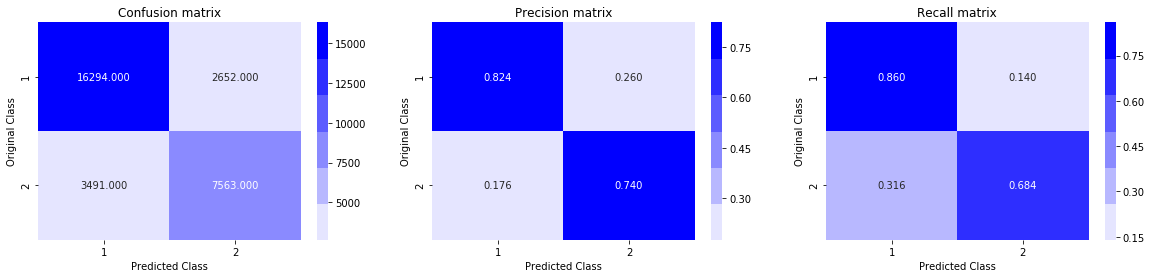

In [77]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

<h1> 5. Assignments </h1>

1. Try out models (Logistic regression, Linear-SVM) with simple TF-IDF vectors instead of TD_IDF weighted word2Vec.
2. Hyperparameter tune XgBoost using RandomSearch to reduce the log-loss.


# 5.2 XGBOOST with Hyperparameter tuning

In [53]:
import xgboost as xgb
max_depth=[1,2,3,4,5,6]
train_loss=[]
cv_loss=[]
for i in max_depth:
      GBDT=xgb.XGBClassifier(max_depth=i,n_jobs=2)
      GBDT.fit(X_train,Y_train)
      y_train_predict=GBDT.predict_proba(X_train)[:,1]
      y_cv_predict=GBDT.predict_proba(X_cv)[:,1]
      train_loss.append(log_loss(Y_train,y_train_predict))
      cv_loss.append(log_loss(Y_cv,y_cv_predict))
      print("Max_depth =",i,"\t","cv_loss:",log_loss(Y_cv,y_cv_predict),"\t","train_loss:",log_loss(Y_train,y_train_predict))
print(min(cv_loss))

Max_depth = 1 	 cv_loss: 0.4396754124348991 	 train_loss: 0.44048952079053433
Max_depth = 2 	 cv_loss: 0.41417994693691695 	 train_loss: 0.41255354427042956
Max_depth = 3 	 cv_loss: 0.3969797175994105 	 train_loss: 0.3896398304689523
Max_depth = 4 	 cv_loss: 0.38884595105880104 	 train_loss: 0.3706833111876017
Max_depth = 5 	 cv_loss: 0.38239849931335185 	 train_loss: 0.3466076367616907
Max_depth = 6 	 cv_loss: 0.37936163130448375 	 train_loss: 0.31791520020740266
0.37936163130448375


In [56]:
n_estimators=[150,200,250,300,500]
train_loss1=[]
cv_loss1=[]
for i in n_estimators:
      GBDT=xgb.XGBClassifier(max_depth=3,n_estimators=i,n_jobs=2,class_weight="balanced")
      GBDT.fit(X_train,Y_train)
      y_train_predict=GBDT.predict_proba(X_train)[:,1]
      y_cv_predict=GBDT.predict_proba(X_cv)[:,1]
      train_loss1.append(log_loss(Y_train,y_train_predict))
      cv_loss1.append(log_loss(Y_cv,y_cv_predict))
      print("Max_depth =3,n_estimators=",i,"\t","cv_loss:",log_loss(Y_cv,y_cv_predict),"\t","train_loss:",log_loss(Y_train,y_train_predict))
print(min(cv_loss1))

Max_depth =3,n_estimators= 150 	 cv_loss: 0.3899725200337058 	 train_loss: 0.37678937790309386
Max_depth =3,n_estimators= 200 	 cv_loss: 0.38623528972416205 	 train_loss: 0.36677025510895156
Max_depth =3,n_estimators= 250 	 cv_loss: 0.3839128047956463 	 train_loss: 0.35876531942714135
Max_depth =3,n_estimators= 300 	 cv_loss: 0.3822687582189404 	 train_loss: 0.35126600118277534
Max_depth =3,n_estimators= 500 	 cv_loss: 0.37860888268723736 	 train_loss: 0.3266659782813317
0.37860888268723736


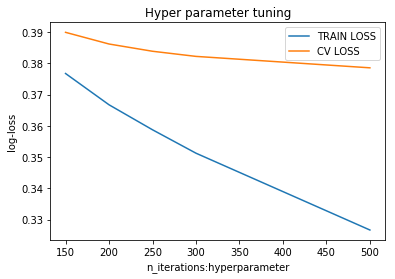

In [57]:
plt.plot(n_estimators,train_loss1,label="TRAIN LOSS")
plt.plot(n_estimators,cv_loss1,label="CV LOSS")
plt.legend()
plt.xlabel("n_iterations:hyperparameter")
plt.ylabel("log-loss")
plt.title("Hyper parameter tuning")
plt.show()

In [59]:
optimal_max_depth=3
optimal_n_estimators=250
optimalgbdt=xgb.XGBClassifier(max_depth=3,n_estimators=250,n_jobs=2,class_weight="balanced")
optimalgbdt.fit(X_train,Y_train)
y_train_predict=optimalgbdt.predict_proba(X_train)[:,1]
y_test_predict=optimalgbdt.predict_proba(X_test)[:,1]

In [60]:
log_loss(Y_test,y_test_predict)

0.38242689803714475

Total number of data points : 30000


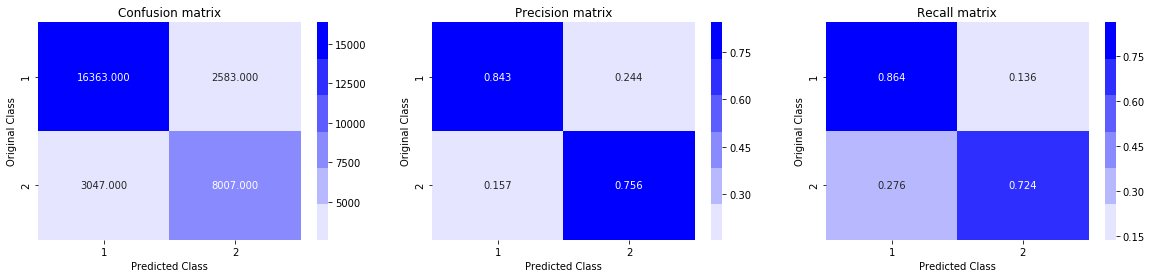

In [91]:
predicted_y =np.array(y_test_predict>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

# 5.1 Logistic regression, Linear-SVM with simple TF-IDF vectors

In [16]:
X_train_tfidf=pd.read_csv('tfidfw2v_train.csv',sep='\t')

In [17]:
print(X_train_tfidf.shape)
X_train_tfidf.columns

(46897, 34)


Index(['Unnamed: 0', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'q1_feats_m',
       'q2_feats_m', 'Y_labels'],
      dtype='object')

In [18]:
X_train_tfidf=X_train_tfidf.drop(['Unnamed: 0','Y_labels','q1_feats_m','q2_feats_m'], axis=1)

In [19]:
X_train_tfidf.columns

Index(['qid1', 'qid2', 'question1', 'question2', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2', 'cwc_min',
       'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max', 'last_word_eq',
       'first_word_eq', 'abs_len_diff', 'mean_len', 'token_set_ratio',
       'token_sort_ratio', 'fuzz_ratio', 'fuzz_partial_ratio',
       'longest_substr_ratio'],
      dtype='object')

In [20]:
Q1_train=X_train_tfidf['question1']
Q2_train=X_train_tfidf['question2']

In [21]:
type(Q1_train)

pandas.core.series.Series

TF-IDF VECTORS FOR TRAIN DATA

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
questions = list(X_train_tfidf['question1'])

tfidf_for_question1 = TfidfVectorizer(lowercase=False)
tfidf_for_question1.fit(questions)
X_train_tfidf_Q1=tfidf_for_question1.transform(Q1_train)

In [23]:
X_train_tfidf_Q1.shape

(46897, 26005)

In [24]:
questions2=list(X_train_tfidf['question2'])

tfidf_for_question2=TfidfVectorizer(lowercase=False)
tfidf_for_question2.fit(questions2)
X_train_tfidf_Q2=tfidf_for_question2.transform(Q2_train)

In [25]:
X_train_tfidf_Q2.shape

(46897, 24163)

In [26]:
X_train_tfidf=X_train_tfidf.drop(['qid1','qid2','question1','question2'], axis=1)

In [27]:
X_train_tfidf_Q2.shape

(46897, 24163)

In [28]:
import scipy
Final_X_train=scipy.sparse.hstack((X_train_tfidf,X_train_tfidf_Q1,X_train_tfidf_Q2))

In [29]:
Final_X_train.shape

(46897, 50194)

TF-IDF VECTORS FOR CV DATA

In [30]:
X_cv_tfidf=pd.read_csv('X_cv1beforetfidfw2v.csv',sep='\t')

In [31]:
X_cv_tfidf.columns

Index(['Unnamed: 0', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'Y_labels'],
      dtype='object')

In [32]:
X_cv_tfidf=X_cv_tfidf.drop(['Unnamed: 0','qid1','qid2','Y_labels'], axis=1)

In [34]:
Q1_CV=X_cv_tfidf['question1']
Q2_CV=X_cv_tfidf['question2']

In [35]:
X_cv_tfidf=X_cv_tfidf.drop(['question1','question2'],axis=1)

In [36]:
X_cv_tfidf_Q1=tfidf_for_question1.transform(Q1_CV)
X_cv_tfidf_Q2=tfidf_for_question2.transform(Q2_CV)

In [38]:
Final_X_cv=scipy.sparse.hstack((X_cv_tfidf,X_cv_tfidf_Q1,X_cv_tfidf_Q2))
Final_X_cv.shape

(23100, 50194)

TF-IDF VECTORS FOR TEST DATA

In [39]:
X_test_tfidf=pd.read_csv('X_test1beforetfidfw2v.csv',sep='\t')

In [40]:
X_test_tfidf=X_test_tfidf.drop(['Unnamed: 0','qid1','qid2','Y_labels'], axis=1)

In [41]:
Q1_TEST=X_test_tfidf['question1']
Q2_TEST=X_test_tfidf['question2']
X_test_tfidf=X_test_tfidf.drop(['question1','question2'],axis=1)
X_test_tfidf_Q1=tfidf_for_question1.transform(Q1_TEST)
X_test_tfidf_Q2=tfidf_for_question2.transform(Q2_TEST)
Final_X_test=scipy.sparse.hstack((X_test_tfidf,X_test_tfidf_Q1,X_test_tfidf_Q2))
Final_X_test.shape

(30000, 50194)

In [42]:
Y_train.shape

(46897,)

# Logistic Regression

For values of alpha =  1e-05 The log loss is: 0.5064007891513411
For values of alpha =  0.0001 The log loss is: 0.5063702864597455
For values of alpha =  0.001 The log loss is: 0.50461019912201
For values of alpha =  0.01 The log loss is: 0.5044655249448922
For values of alpha =  0.1 The log loss is: 0.5090711554788038
For values of alpha =  1 The log loss is: 0.5317695534539874
For values of alpha =  10 The log loss is: 0.5704474279383996


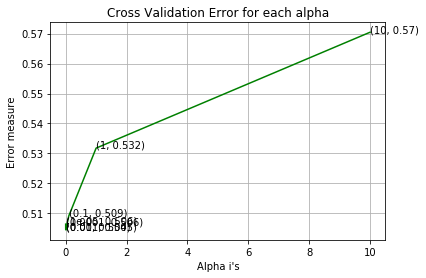

For values of best alpha =  0.01 The train log loss is: 0.5037571252561217
For values of best alpha =  0.01 The test log loss is: 0.5035291157376197
Total number of data points : 30000


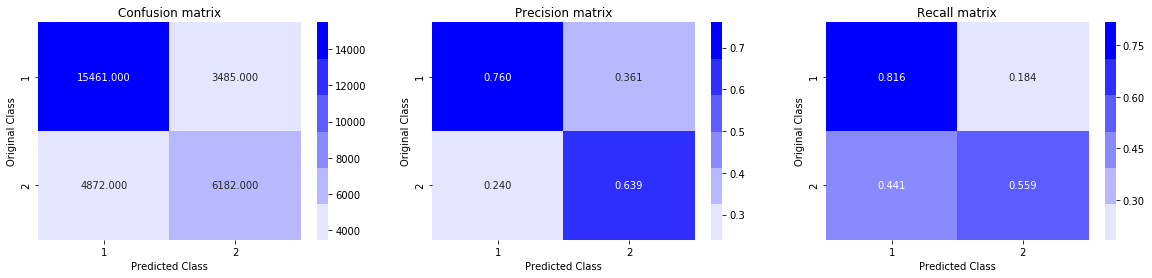

In [43]:

alpha = [10 ** x for x in range(-5, 2)] 


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,class_weight='balanced')
    clf.fit(Final_X_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(Final_X_train, Y_train)
    predict_cv = sig_clf.predict_proba(Final_X_cv)
    log_error_array.append(log_loss(Y_cv, predict_cv, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_cv, predict_cv, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42,class_weight='balanced')
clf.fit(Final_X_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(Final_X_train, Y_train)

predict_train = sig_clf.predict_proba(Final_X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_train, labels=clf.classes_, eps=1e-15))
predict_test = sig_clf.predict_proba(Final_X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_test, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_test,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

# Linear-SVM

For values of alpha =  1e-05 The log loss is: 0.49420735106588476
For values of alpha =  0.0001 The log loss is: 0.5033761595802462
For values of alpha =  0.001 The log loss is: 0.5141768959783535
For values of alpha =  0.01 The log loss is: 0.5500936865243569
For values of alpha =  0.1 The log loss is: 0.5480905095959342
For values of alpha =  1 The log loss is: 0.5931264237875715
For values of alpha =  10 The log loss is: 0.6310018066203327


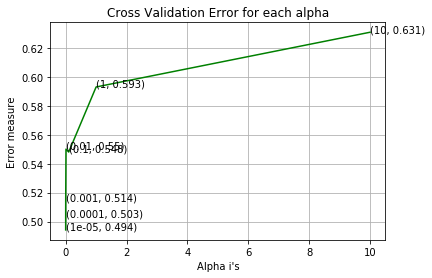

For values of best alpha =  1e-05 The train log loss is: 0.49355051200006816
For values of best alpha =  1e-05 The test log loss is: 0.4915593608517571
Total number of data points : 30000


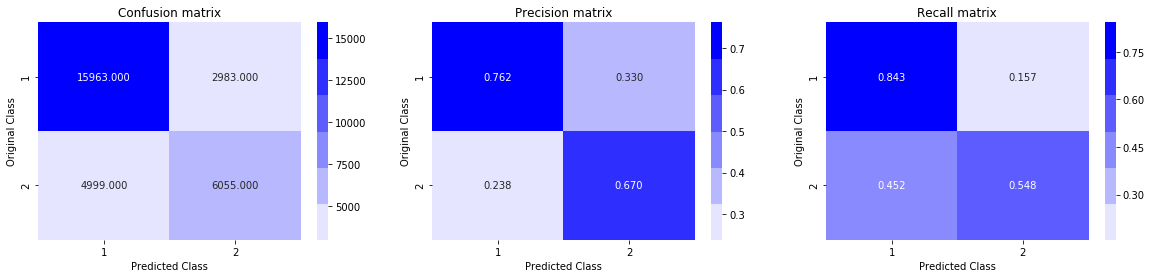

In [44]:
alpha = [10 ** x for x in range(-5, 2)] 


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
    clf.fit(Final_X_train, Y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(Final_X_train, Y_train)
    predict_cv = sig_clf.predict_proba(Final_X_cv)
    log_error_array.append(log_loss(Y_cv,predict_cv, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(Y_cv,predict_cv, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42,class_weight='balanced')
clf.fit(Final_X_train, Y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(Final_X_train, Y_train)

predict_train = sig_clf.predict_proba(Final_X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(Y_train, predict_train, labels=clf.classes_, eps=1e-15))
predict_test = sig_clf.predict_proba(Final_X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(Y_test, predict_test, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_test,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(Y_test, predicted_y)

# CONCLUSIONS

1.First I sample 100k Datapoints from train.csv

2.Featurize the data using some basic feature enggineering and advanced features using fuzzywuzzy and nlp.

3.Analyized the extracted features using pairplots,violin plots

4.visualize the data using TSNE plots.

5.Featurize the tfidfw2v features using glove vectors.

6.Applied logistic regression,linear svm and xgboost and observed the models performance using logloss.

7.Logistic regression,linear svm are giving good results while using tfidf vectors

8.At last represented the results using prettytable library.



In [61]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model", "Vectorizer","Test LOSS"]

x.add_row(["LOGISTIC REGRESSION","TFIDFW2V",0.549])
x.add_row(["LINEAR SVM","TFIDFW2V",0.541])
x.add_row(["XGBOOST WITHOUT HYPERPARAMETER TUNING","TFIDVW2V",0.392])
x.add_row(["XGBOOST WITH HYPERPERAMETER TUNING","TFIDFW2V",0.382])
x.add_row(["LOGISTIC REGRESSION","TFIDF",0.503])
x.add_row(["LINEAR SVM","TFIDF",0.491])


print(x)

+---------------------------------------+------------+-----------+
|                 Model                 | Vectorizer | Test LOSS |
+---------------------------------------+------------+-----------+
|          LOGISTIC REGRESSION          |  TFIDFW2V  |   0.549   |
|               LINEAR SVM              |  TFIDFW2V  |   0.541   |
| XGBOOST WITHOUT HYPERPARAMETER TUNING |  TFIDVW2V  |   0.392   |
|   XGBOOST WITH HYPERPERAMETER TUNING  |  TFIDFW2V  |   0.382   |
|          LOGISTIC REGRESSION          |   TFIDF    |   0.503   |
|               LINEAR SVM              |   TFIDF    |   0.491   |
+---------------------------------------+------------+-----------+
